In [1]:
import strongholds
import strongholds.graphing as mplt

import numpy as np

from matplotlib import pyplot as plt, gridspec
from matplotlib.widgets import Button, Slider

fixed_rng = np.random.default_rng(0)

To predict where the nearest stronghold to the player will be, we can simply generate many different worlds, find the closest stronghold to each one, and plot a histogram of the results.

In [2]:
stronghold_sets = strongholds.generation_heatmap(1*10**4, rng=fixed_rng, concatenate=False)

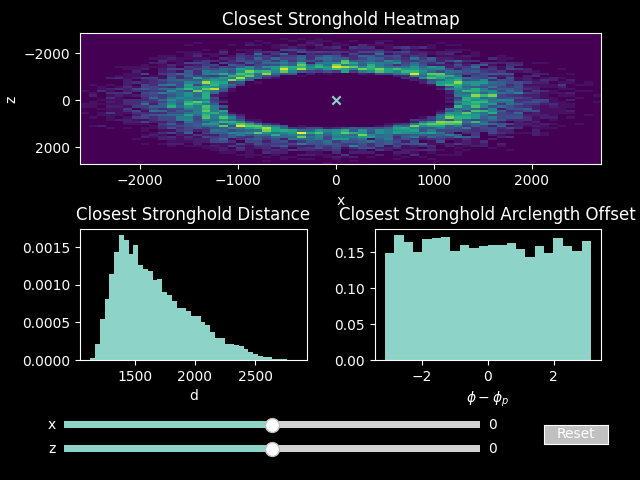

In [9]:
%matplotlib widget

# 2x2 grid
gs = gridspec.GridSpec(2, 2)

fig = plt.figure()
ax = []
ax.append(fig.add_subplot(gs[0, :]))
ax.append(fig.add_subplot(gs[1, 0]))
ax.append(fig.add_subplot(gs[1, 1]))

fig.tight_layout(pad=2, h_pad=3.5)
fig.subplots_adjust(left=0.125, bottom=0.25)

#fig, ax = plt.subplots(3, 1, figsize=(6, 9))

ax[0].set_title("Closest Stronghold Heatmap")
ax[0].set_xlabel("x")
ax[0].set_ylabel("z")

ax[1].set_title("Closest Stronghold Distance")
ax[1].set_xlabel("d")

ax[2].set_title("Closest Stronghold Arclength Offset")
ax[2].set_xlabel("$\\phi - \\phi_p$")

player = strongholds.rectpoint(0, 0)
closest_strongholds = strongholds.closest_stronghold(player, stronghold_sets)

distances = strongholds.radius(closest_strongholds - player)
angles = strongholds.angle(closest_strongholds) - strongholds.angle(player)

# xz plot
_, _, _, hist2d = ax[0].hist2d(closest_strongholds.real,
                         closest_strongholds.imag,
                         bins=60, density=True)
player_point = ax[0].scatter(player.real, player.imag, marker="x", zorder=1000)

# radii and angles plot
_, _, hist_d = ax[1].hist(distances, bins="auto", density=True)
_, _, hist_phi = ax[2].hist(angles, bins="auto", density=True)

# add sliders
ax_x = fig.add_axes([0.1, 0.1, 0.65, 0.03])
ax_z = fig.add_axes([0.1, 0.05, 0.65, 0.03])
x_slider = Slider(ax=ax_x, label="x", valmin=-25000, valmax=25000, valinit=0)
z_slider = Slider(ax=ax_z, label="z", valmin=-25000, valmax=25000, valinit=0)

def update(val=None):
    global hist2d, hist_d, hist_phi
    # update player location and resulting outputs
    player = strongholds.rectpoint(x_slider.val, z_slider.val)
    closest_strongholds = strongholds.closest_stronghold(player, stronghold_sets)

    distances = strongholds.radius(closest_strongholds - player)
    angles = strongholds.angle(closest_strongholds) - strongholds.angle(player)

    # update xz plot
    hist2d.remove()
    _, _, _, hist2d = ax[0].hist2d(closest_strongholds.real,
                         closest_strongholds.imag,
                         bins=60, density=True)
    player_point.set_offsets(strongholds.math.to_xz(player))

    # update radii and angles plots
    hist_d.remove()
    hist_phi.remove()
    
    _, _, hist_d = ax[1].hist(distances, bins="auto", density=True)
    _, _, hist_phi = ax[2].hist(angles, bins="auto", density=True)

    # update view
    for ax_ in ax:
        ax_.relim()
        ax_.autoscale_view()

    mplt.flip_zaxis(ax[0])

x_slider.on_changed(update)
z_slider.on_changed(update)

resetax = fig.add_axes((0.85, 0.075, 0.1, 0.04))
button = Button(resetax, 'Reset', color="silver", hovercolor="blue")

def resetSlider(event) -> None:
    x_slider.reset()
    z_slider.reset()

button.on_clicked(resetSlider)

mplt.flip_zaxis(ax[0])